In [1]:
import sys
sys.path.append('/Users/JIC115/Desktop/HEseg_prj/hovernet_modeling/final_v2/scripts')

In [2]:
from hv_util.util_train_prep import *
from hv_util.util_eval_prep import * 

from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report
from sklearn.preprocessing import label_binarize

import pandas as pd 
import matplotlib.pyplot as plt
pd.set_option('display.max_columns',None)

In [27]:
wd_fig = Path('/Users/JIC115/Desktop')
wd_ck = Path('/Users/JIC115/Desktop/HEseg_prj/HNSCC_PDO_model/data3/checkpoints9')
data_wd = Path('/Users/JIC115/Desktop/HEseg_prj/hovernet_modeling/final_v2/data_output/hv_train_val_dataset/') 
type_path = '/Users/JIC115/Desktop/HEseg_prj/hovernet_modeling/final_v2/scripts/hv_util/type_info_3chl.json'

## 1. Choose best model

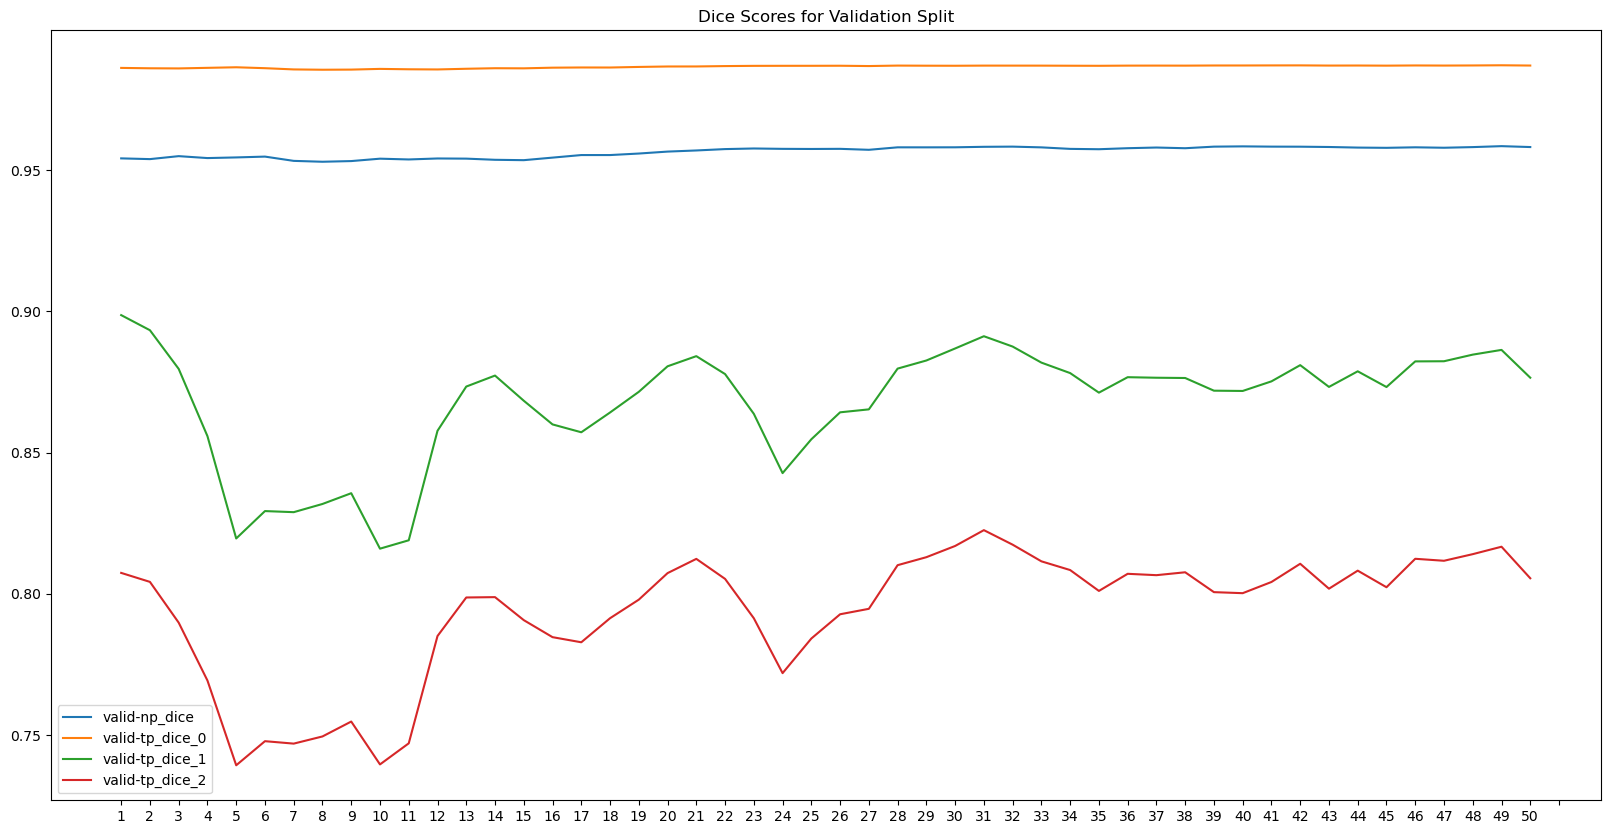

In [32]:
#pn = wd_ck.joinpath('stats0.json') 
with open(pn) as f:
    data = json.load(f)
df = pd.DataFrame(data).T
df.filter(regex='valid.*dice').plot(xticks=range(0,51),figsize = (20,10))
plt.title('Dice Scores for Validation Split')
plt.savefig(wd_fig.joinpath('phase0_val_dice.pdf'))

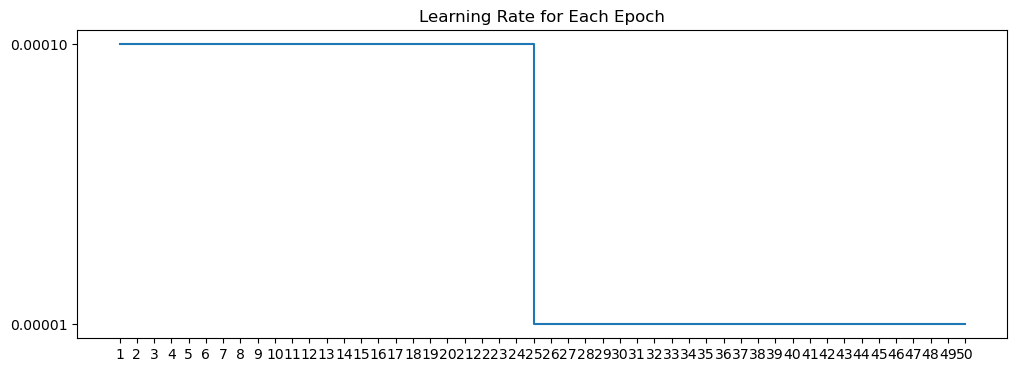

In [28]:
plt.figure(figsize=(12, 4))
plt.step(x=range(1,51),y=df['train-lr-net'])
plt.xticks(range(1,51))
plt.yticks([0.0001,0.00001])
plt.title('Learning Rate for Each Epoch')
plt.savefig(wd_fig.joinpath('learning_rate.pdf'))

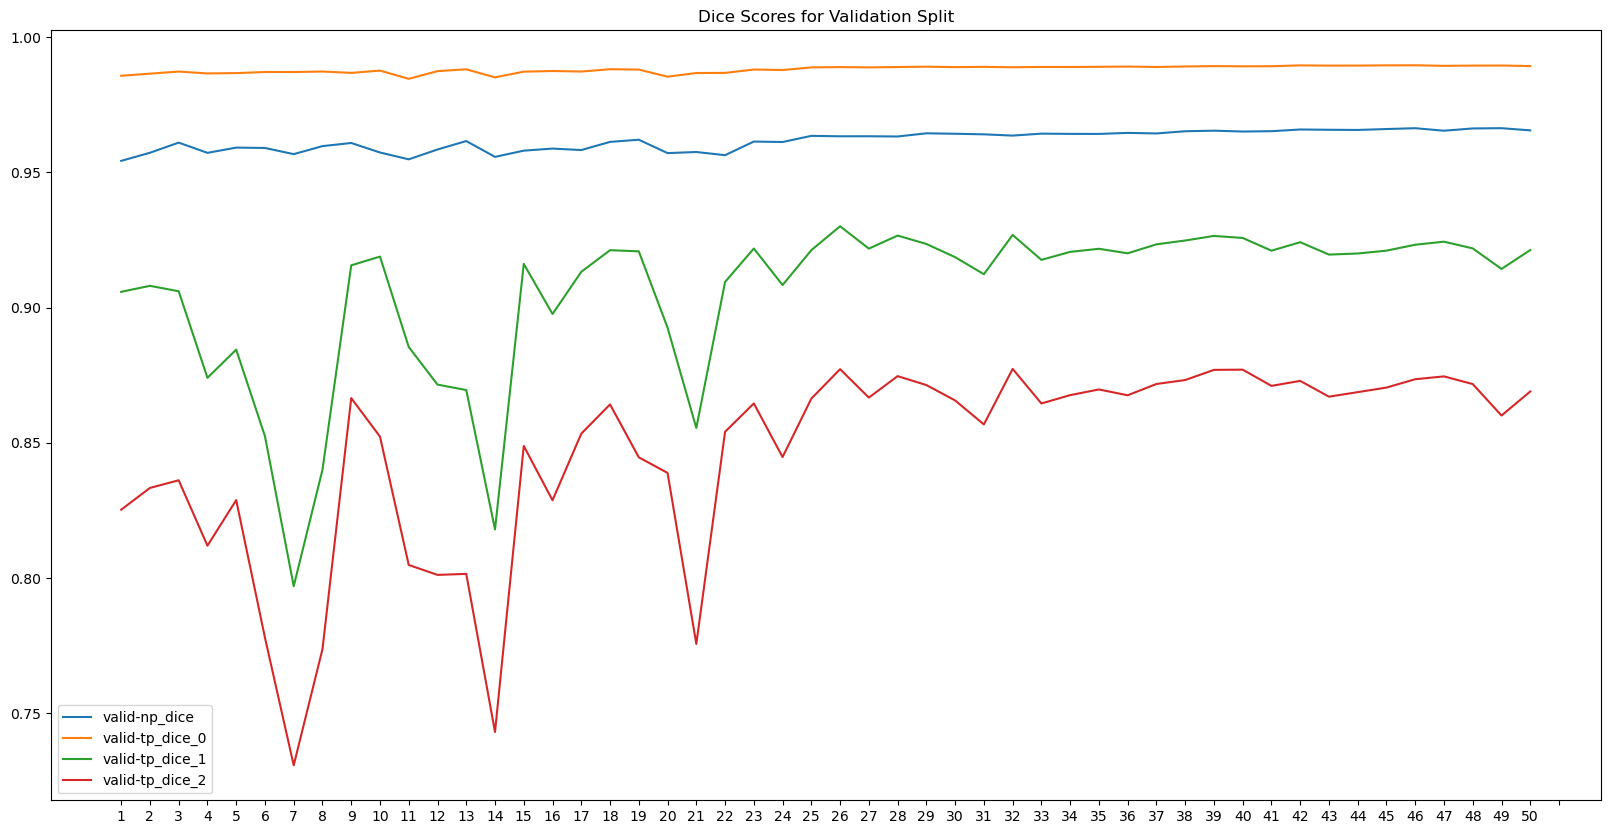

In [33]:
pn = wd_ck.joinpath('stats1.json')
with open(pn) as f:
    data = json.load(f)
df = pd.DataFrame(data).T
df.filter(regex='valid.*dice').plot(xticks=range(0,51),figsize = (20,10))
plt.title('Dice Scores for Validation Split')
plt.savefig(wd_fig.joinpath('phase1_val_dice.pdf'))

In [10]:
df.iloc[[31],:]   #epoch32

,valid-np_acc,valid-np_dice,valid-tp_dice_0,valid-tp_dice_1,valid-tp_dice_2,valid-hv_mse,train-loss_tp_bce,train-loss_tp_dice,train-loss_np_bce,train-loss_np_dice,train-loss_hv_mse,train-loss_hv_msge,train-overall_loss,train-lr-net
32,0.984821,0.96364,0.988903,0.926893,0.877372,0.025619,0.10786,0.248031,0.061267,0.075509,0.017206,0.109038,0.61891,0.00001


##### Best model is phase2 epoch 45, use it to run predictions

## 1. train data split metrics

### 1.1 Gen train_true_gson

In [15]:
###### extract images from pathes
indir = data_wd.joinpath('train2')
outdir = data_wd.joinpath('train2_patch_im')
extract_image (outdir,indir)

###### extract masks from pathes       
outdir = data_wd.joinpath('train2_patch_mask')
extract_mask (outdir,indir)

###### convert true mask to true gson
celltypes = ['background','normal','tumor']
colors=[[255,255,255],[255, 0, 0],[0, 255, 0]]

indir = data_wd.joinpath('train2_patch_mask')
outdir = data_wd.joinpath('train2_patch_true_gson')
hvmask2gson (outdir,indir,celltypes,colors,resize=False)

### 1.2 Gen train_pred_gson

In [16]:
###### json2gson
indir = data_wd.joinpath('json')
outdir = data_wd.joinpath('train2_patch_pred_gson')
df = json2gson(outdir,type_path,indir)
df

,background,normal,tumor
"HN23-10730-p4_H&E_1 [x=1239,y=475,w=256,h=256]",0,0,16
"HN23-10730-p4_H&E_1 [x=1268,y=203,w=256,h=256]",0,0,12
"HN23-10730-p4_H&E_1 [x=1304,y=2183,w=256,h=256]",0,0,16
"HN23-10730-p4_H&E_1 [x=1322,y=1834,w=256,h=256]",0,0,11
"HN23-10730-p4_H&E_1 [x=1357,y=1567,w=256,h=256]",0,0,11
...,...,...,...
"HN24-10909-P2_H&E [x=8908,y=11182,w=256,h=256]",0,1,16
"HN24-10909-P2_H&E [x=9149,y=10513,w=256,h=256]",0,0,10
"HN24-10909-P2_H&E [x=9399,y=12156,w=256,h=256]",0,1,16
"HN24-10909-P2_H&E [x=9526,y=11494,w=256,h=256]",0,0,17


### 2.3 Get train metrics: precision etc

In [5]:
wd_fig = Path('/Users/JIC115/Desktop/roc_pdf')

In [4]:
gs_true_dir = data_wd.joinpath('train2_patch_true_gson')
gs_pred_dir = data_wd.joinpath('train2_patch_pred_gson')
celltypes = ['normal','tumor']
shape = (256,256)
df = gen_ypred_ytrue(gs_true_dir,gs_pred_dir,celltypes,shape)

#### 2.3.1 detection metrics

,cell_in_true,cell_not_in_true,accuracy,macro avg,weighted avg
precision,0.909833,0.0,0.841136,0.454917,0.833991
sensitivity,0.917628,0.0,0.841136,0.458814,0.841136
f1-score,0.913714,0.0,0.841136,0.456857,0.837548
support,3035.000000,276.0,0.841136,3311.000000,3311.000000


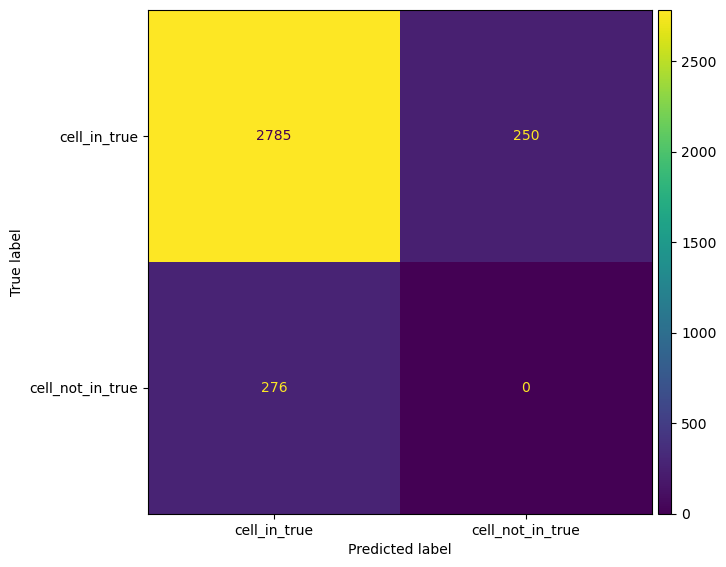

In [7]:
df['dtc_ytrue'] = np.where(df.ytrue != 'NA_true', 'cell_in_true', 'cell_not_in_true')
df['dtc_ypred'] = np.where(df.ypred != 'NA_pred', 'cell_in_true', 'cell_not_in_true')

ytrue = df.dtc_ytrue
ypred = df.dtc_ypred

#-------- confusion plot
conf_mat = confusion_matrix(ytrue, ypred) # sorted by alphabeta order of labels !!!
label = sorted(['cell_in_true','cell_not_in_true']) 
cmat_disp = ConfusionMatrixDisplay(conf_mat,display_labels=label)

# customize :
fig, ax = plt.subplots(figsize=(6.5,6.6))    # set plot figsize
cmat_disp.plot(ax=ax, colorbar=False)    # Deactivate default colorbar,size does not match with plot

# Adding custom colorbar
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(cmat_disp.im_,  cax=cax)

#-------- perf report
report = pd.DataFrame(classification_report(ytrue, ypred, output_dict = True))
report.rename(index = {'recall':'sensitivity'},inplace=True)
report

#### 2.3.2  classification metrics

In [8]:
df = df.query("ypred != 'NA_pred' and ytrue != 'NA_true'")
print(df.ypred.unique())
print(df.ytrue.unique())

['tumor' 'normal']
['tumor' 'normal']


,normal,tumor,accuracy,macro avg,weighted avg
precision,0.976678,0.944526,0.960862,0.960602,0.961358
sensitivity,0.947874,0.975132,0.960862,0.961503,0.960862
f1-score,0.962061,0.959585,0.960862,0.960823,0.960881
support,1458.000000,1327.000000,0.960862,2785.000000,2785.000000


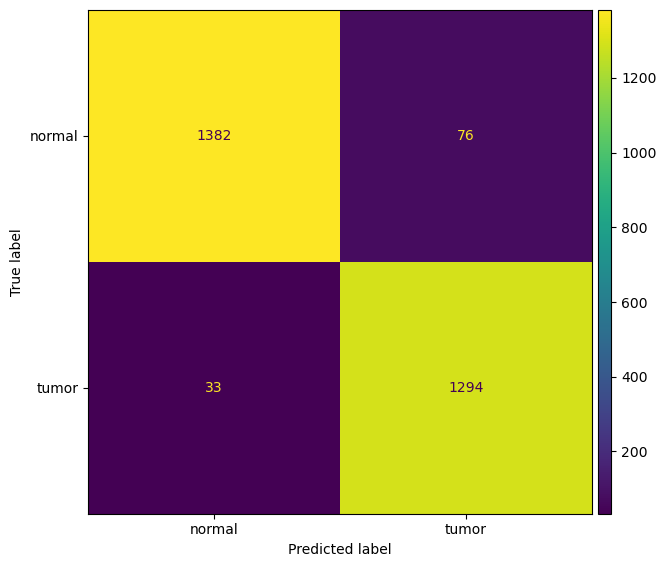

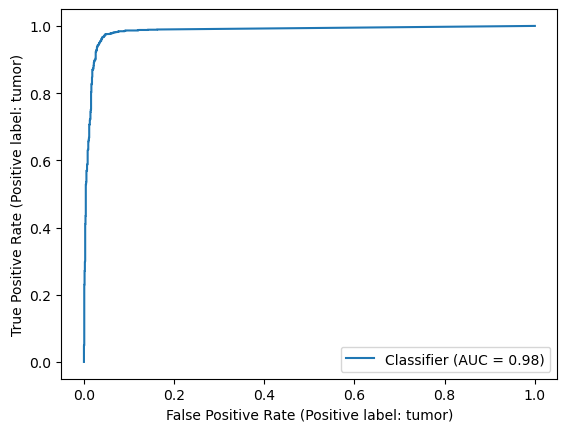

In [9]:
ytrue = df.ytrue
ypred = df.ypred

#-------- confusion plot
conf_mat = confusion_matrix(ytrue, ypred) # sorted by alphabeta order of labels !!!
label = sorted(['normal','tumor']) 
cmat_disp = ConfusionMatrixDisplay(conf_mat,display_labels=label)

# customize :
fig, ax = plt.subplots(figsize=(6.5,6.6))    # set plot figsize
cmat_disp.plot(ax=ax, colorbar=False)    # Deactivate default colorbar,size does not match with plot

# Adding custom colorbar
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(cmat_disp.im_,  cax=cax)

#-------- ROC plot
yprob = df.prob_tumor
RocCurveDisplay.from_predictions(ytrue,yprob,pos_label='tumor')
plt.savefig(wd.joinpath('train_tile_detection_roc.pdf'))

#-------- perf report
report = pd.DataFrame(classification_report(ytrue, ypred, output_dict = True))
report.rename(index = {'recall':'sensitivity'},inplace=True)
report

## 2. Val data split metrics

### 2.1  Gen val_true_gson 

In [5]:
###### extract images from pathes
indir = data_wd.joinpath('train2')
outdir = data_wd.joinpath('train2_patch_im')
extract_image (outdir,indir)

###### extract masks from pathes       
outdir = data_wd.joinpath('train2_patch_mask')
extract_mask (outdir,indir)

###### convert true mask to true gson
celltypes = ['background','normal','tumor']
colors=[[255,255,255],[255, 0, 0],[0, 255, 0]]

indir = data_wd.joinpath('train2_patch_mask')
outdir = data_wd.joinpath('train2_patch_true_gson')
hvmask2gson (outdir,indir,celltypes,colors,resize=False)

### 2.2  Gen val_pred_gson

In [9]:
###### json2gson
indir = data_wd.joinpath('json')
outdir = data_wd.joinpath('train2_patch_pred_gson')
df = json2gson(outdir,type_path,indir)
df

,background,normal,tumor
"HN23-10730-p4_H&E_1 [x=1001,y=213,w=256,h=256]",0,0,9
"HN23-10730-p4_H&E_1 [x=1568,y=1296,w=256,h=256]",0,0,9
"HN23-10730-p4_H&E_1 [x=1671,y=1563,w=256,h=256]",0,0,13
"HN23-10752-p1_H&E_1 [x=1448,y=1710,w=256,h=256]",0,0,17
"HN23-10752-p1_H&E_1 [x=1530,y=1437,w=256,h=256]",0,0,22
...,...,...,...
"HN24-10909-P2_H&E [x=7515,y=11212,w=256,h=256]",0,0,10
"HN24-10909-P2_H&E [x=7869,y=11918,w=256,h=256]",0,5,18
"HN24-10909-P2_H&E [x=8280,y=12146,w=256,h=256]",0,4,9
"HN24-10909-P2_H&E [x=8890,y=10892,w=256,h=256]",0,1,13


###  2.3 Get eval metrics: precision etc

In [10]:
gs_true_dir = data_wd.joinpath('val2_patch_true_gson')
gs_pred_dir = data_wd.joinpath('val2_patch_pred_gson')
celltypes = ['normal','tumor']
shape = (256,256)

df = gen_ypred_ytrue(gs_true_dir,gs_pred_dir,celltypes,shape)

,cell_in_true,cell_not_in_true,accuracy,macro avg,weighted avg
precision,0.914045,0.0,0.842887,0.457022,0.841594
sensitivity,0.915450,0.0,0.842887,0.457725,0.842887
f1-score,0.914747,0.0,0.842887,0.457373,0.842240
support,1301.000000,112.0,0.842887,1413.000000,1413.000000


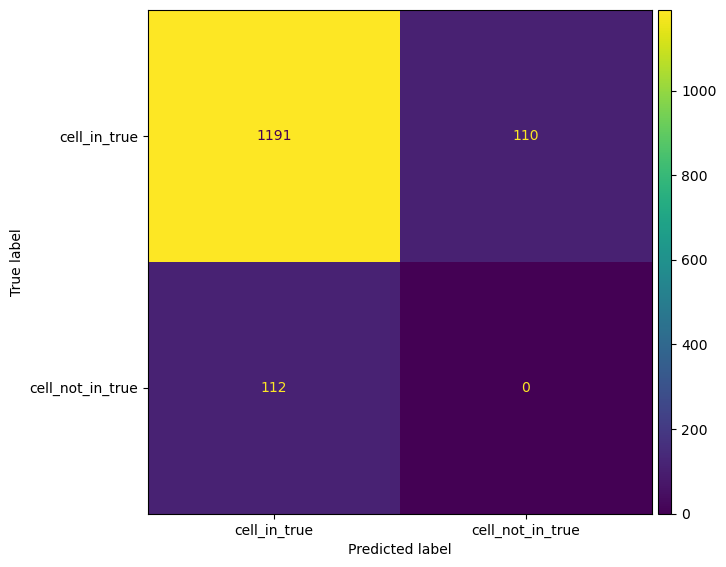

In [11]:
df['dtc_ytrue'] = np.where(df.ytrue != 'NA_true', 'cell_in_true', 'cell_not_in_true')
df['dtc_ypred'] = np.where(df.ypred != 'NA_pred', 'cell_in_true', 'cell_not_in_true')

ytrue = df.dtc_ytrue
ypred = df.dtc_ypred

#-------- confusion plot
conf_mat = confusion_matrix(ytrue, ypred) # sorted by alphabeta order of labels !!!
label = sorted(['cell_in_true','cell_not_in_true']) 
cmat_disp = ConfusionMatrixDisplay(conf_mat,display_labels=label)

# customize :
fig, ax = plt.subplots(figsize=(6.5,6.6))    # set plot figsize
cmat_disp.plot(ax=ax, colorbar=False)    # Deactivate default colorbar,size does not match with plot

# Adding custom colorbar
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(cmat_disp.im_,  cax=cax)

#-------- perf report
report = pd.DataFrame(classification_report(ytrue, ypred, output_dict = True))
report.rename(index = {'recall':'sensitivity'},inplace=True)
report

In [12]:
df = df.query("ypred != 'NA_pred' and ytrue != 'NA_true'")
print(df.ypred.unique())
print(df.ytrue.unique())

['tumor' 'normal']
['tumor' 'normal']


,normal,tumor,accuracy,macro avg,weighted avg
precision,0.987147,0.866828,0.945424,0.926987,0.949970
sensitivity,0.933171,0.972826,0.945424,0.952999,0.945424
f1-score,0.959400,0.916773,0.945424,0.938087,0.946229
support,823.000000,368.000000,0.945424,1191.000000,1191.000000


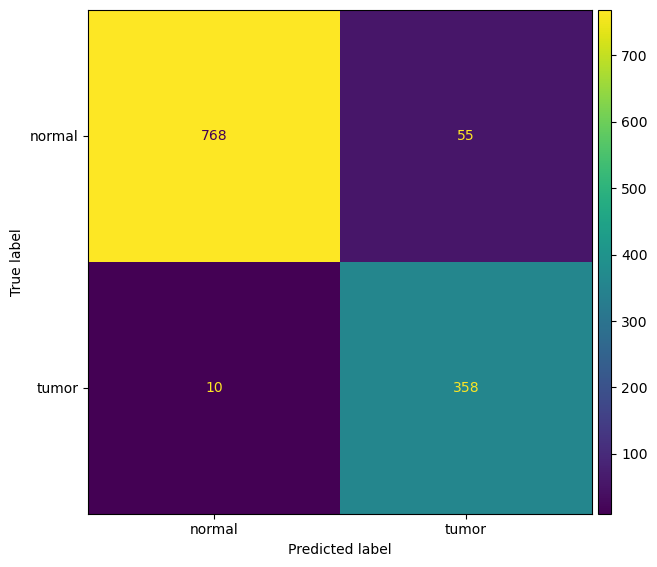

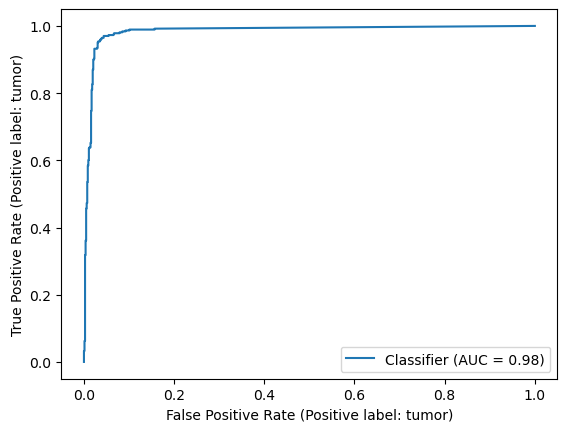

In [13]:
ytrue = df.ytrue
ypred = df.ypred

#-------- confusion plot
conf_mat = confusion_matrix(ytrue, ypred) # sorted by alphabeta order of labels !!!
label = sorted(['normal','tumor']) 
cmat_disp = ConfusionMatrixDisplay(conf_mat,display_labels=label)

# customize :
fig, ax = plt.subplots(figsize=(6.5,6.6))    # set plot figsize
cmat_disp.plot(ax=ax, colorbar=False)    # Deactivate default colorbar,size does not match with plot

# Adding custom colorbar
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(cmat_disp.im_,  cax=cax)


#-------- ROC plot
yprob = df.prob_tumor
RocCurveDisplay.from_predictions(ytrue,yprob,pos_label='tumor')
plt.savefig(wd.joinpath('val_tile_classification_roc.pdf'))

#-------- perf report
report = pd.DataFrame(classification_report(ytrue, ypred, output_dict = True))
report.rename(index = {'recall':'sensitivity'},inplace=True)
report